<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/4_Sequence_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author TODO

**Generate multiples of $n=5$ (of maximum length $l=4$)**



$$\mathcal{X} = \{0000, ....,9999\}$$

The numbers are constructed autoregressively starting from an initial state (`[BOS]`) and adding each time a digit between 0 and 9 at the end of the already constructed number. The process continues until a special symbol is generated (`[EOS]`) or until the number is of length $l$. As a reward function, we can decide to give a score of $1$ to the multiple of $n$, and a lower and lower score when the considered number is far from a multiple of $n$. A suitable reward function in this case is $R(x) = \lambda^ { - min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}}$ where $q_n(x)$ is the quotient of the Euclidean division of $x$ by $n$, and $\lambda > 1$.

For $n=5$ and $\lambda = 2$ :
$R(x) = \left\{
    \begin{array}{ll}
        1 & \mbox{if } x = 5k \\
        2^{-1} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4=5(k+1)-1 \\
        2^{-2} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3=5(k+1)-2
    \end{array} \ (k \in \mathbb{N})
\right.$





$$Z = \sum_{x \in \mathcal{X}}R(x) = \ ...$$

$$\pi(x)=\frac{R(x)}{Z} = \left\{
    \begin{array}{ll}
        \frac{1}{Z} & \mbox{if } x = 5k \\
        \frac{1}{2Z} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4 \\
        \frac{1}{4Z} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3
    \end{array} \ (k \in \mathbb{N})
\right.$$

In [ ]:
import torch

In [ ]:
def reward_function(x, a, lambda_ = 2, R_0 = 1e-6):
    q = x // a 
    return lambda_**-min(x-a*q, a*(q+1)-x) + R_0

def reward_function11(state, a, lambda_ = 2):
    """state : (bs, slen)"""
    r = torch.Tensor([reward_function(s, a, lambda_) for s in [float("".join([str(s_i) for s_i in s])) for s in state.tolist()]])
    return r

def reward_function22(state, a, lambda_ = 2):
    """state : (bs, slen)"""
    r = torch.Tensor([reward_function(s, a, lambda_) for s in state])
    return r

In [ ]:
# n
#reward_coef = 5
reward_coef = 11


vocab = ["0", "1", "2", "3", "4", "5", "6", "7", "8", '9', '.', ','] # # eos and pad tokens
pad_index = 10
eos_index = 10 + 1

vocab_size = len(vocab)
max_length = 4+1

In [ ]:
xs = torch.arange(0, int("".join(["9"]*max_length)))
all_rewards = reward_function22(xs, reward_coef)
print('total reward', all_rewards.view(-1).logsumexp(0))
true_dist = all_rewards.softmax(0).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


total reward tensor(11.6581)


In [ ]:
tk = torch.tensor(all_rewards).topk(k=20)
modes = tk.indices
print(modes)
print(tk.values)

tensor([121,  77, 110, 154,  44, 143,  88, 198,  11,  55, 165,  22, 176, 132,
        187,  99, 209,  66,  33,   0])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


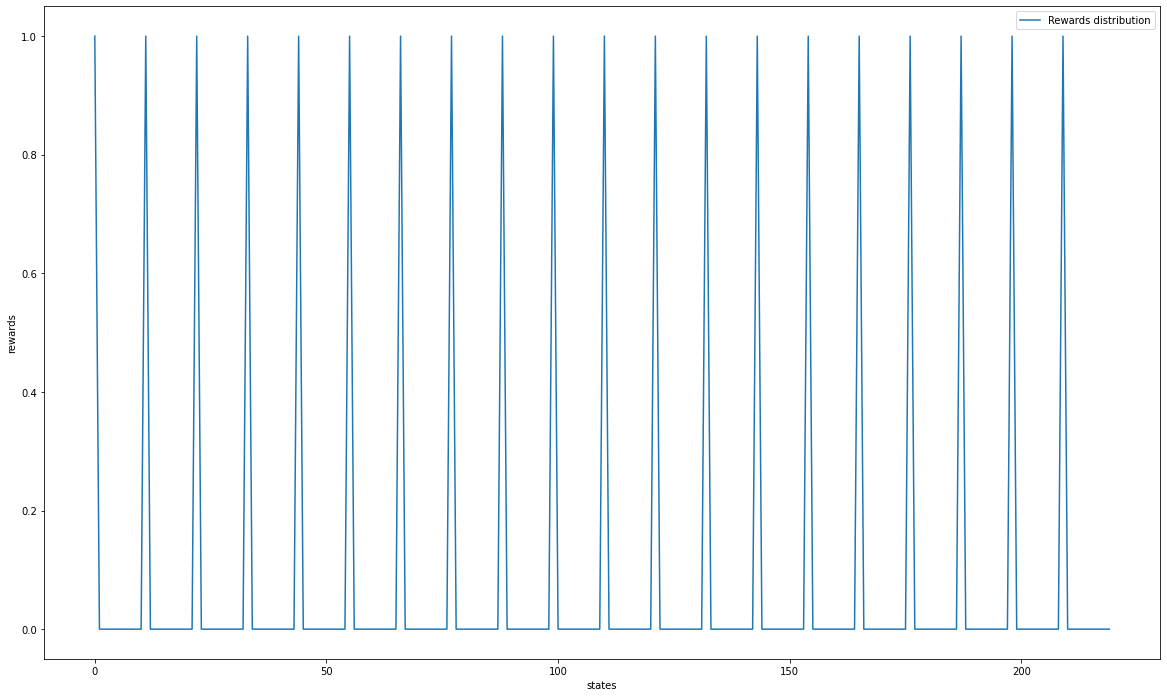

In [ ]:
import matplotlib.pyplot as plt
figsize=(15+5,3*4)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

# observe 20 modes
ax1.plot(xs[:20*reward_coef], all_rewards[:20*reward_coef], label="Rewards distribution")
ax1.set(xlabel='states', ylabel='rewards')
#ax1.set_title('...')
ax1.legend()

#### Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import itertools
import numpy as np

def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

def get_padding_masks(slen, lengths):
    """
    Generate hidden states mask
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]
    # sanity check
    assert mask.size() == (bs, slen)
    return mask

class TransformerModel(nn.Module):

    # params : n_words, eos_index, pad_index, emb_dim

    def __init__(self, params, transformer_layers):
        """
        Transformer model 
        """
        super().__init__()
        # embeddings : one hot is better in this case
        self.embeddings = Embedding(params.n_words, params.emb_dim, padding_idx=params.pad_index)
        # This can be replace by transformer model from torch.nn, huggingface transoformer ...
        self.transformer = transformer_layers

    def forward(self, x, lengths):
        """
        Inputs:
            `x` LongTensor(bs, slen), containing word indices
            `lengths` LongTensor(bs), containing the length of each sentence
        """
        #padding_mask = x != self.pad_index
        #lengths = padding_mask.long().sum(dim=1).to(x.device)
        
        # check inputs
        bs, slen = x.size()
        assert lengths.size(0) == bs
        assert lengths.max().item() <= slen

        # generate masks
        mask = get_padding_masks(slen, lengths)

        # embeddings
        tensor = self.embeddings(x)
        tensor *= mask.unsqueeze(-1).to(tensor.dtype)
        
        # transformer layers
        tensor = self.transformer(tensor)
        
        return tensor

In [ ]:
def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    """makes an MLP with no top layer activation"""
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

# Train

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
params = AttrDict({
    "n_words":vocab_size, 
    "pad_index" : pad_index, 
    "eos_index" : eos_index, 
    "emb_dim" : 100, 
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Z = torch.ones((1,)).to(device)

n_hid = 256
n_layers = 2

mlp = make_mlp([params.emb_dim] + [n_hid] * n_layers + [params.n_words]).to(device)
model = TransformerModel(params, mlp).to(device)
P_B = 1 # DAG & sequence generation => tree 


optim = torch.optim.Adam([ {'params':model .parameters(), 'lr':0.001}, {'params':[Z], 'lr':0.01} ])
Z.requires_grad_()

tensor([1.], requires_grad=True)

In [ ]:
import tqdm

losses_TB = []
zs_TB = []
rewards_TB = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

**Here, we are dealing with trees (each non-initial sentence has only one parent), so $P_B = 1 \Rightarrow logP_B = 0$**

In [ ]:
batch_size = 128
max_len = max_length

n_train_steps = 5000

for it in tqdm.trange(n_train_steps):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)       # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.eos_index)    # we use <EOS> for <BOS> everywhere as start token
    #gen_len = (state != params.pad_index).long().sum(dim=1).to(state.device)
    gen_len = torch.LongTensor(batch_size,).fill_(1)
    unfinished_sents = gen_len.clone().fill_(1)
    cur_len = 1
    #Z = Z(agent.model(generated[:,:cur_len], lengths=gen_len, causal=True)[:,0]).squeeze(1).exp().to(device)

    flag = True
    if flag :
        # detached form  of TB
        ll_diff = torch.zeros((batch_size,)).to(device)
        ll_diff += Z
    else :
        # non-detached form of TB ojective, where we multiply everything before doing the logarithm
        in_probs = torch.ones(batch_size, dtype=torch.float, requires_grad=True).to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        #scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores = tensor.sum(dim=1) # (bs, vocab_size) 
        scores[:,pad_index] = -1e8 # we don't want to generate pad_token
        scores[:,eos_index] = -1e8 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        scores = scores.log_softmax(1)
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents)
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long())
        cur_len = cur_len + 1

        # loss
        if flag :
            #sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            #sample_in_probs[unfinished_sents == 0] = 1.
            #ll_diff += sample_in_probs.log()
            
            ll_diff += scores.gather(1, next_words.unsqueeze(-1)).squeeze(1)
        else :
            sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            sample_in_probs[unfinished_sents == 0] = 1.
            in_probs = in_probs * sample_in_probs
      
        # stop when there is a </s> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function22(generated, reward_coef).to(device) 
    
    optim.zero_grad()
    if flag :
        ll_diff -= R.log()
        loss = (ll_diff**2).sum()/batch_size
    else :
        loss = ((Z*in_probs / R).log()**2).sum()/batch_size

    loss.backward()
    optim.step()

    losses_TB.append(loss.item())
    zs_TB.append(Z.item())
    rewards_TB.append(R.mean().cpu())
    all_visited_TB.extend(generated)
    for state in all_visited_TB :
        if first_visit_TB[int(state)]<0: first_visit_TB[int(state)] = it

    if it%100==0: 
        print('loss =', np.array(losses_TB[-100:]).mean(), 'Z =', Z.item(), "R =", np.array(rewards_TB[-100:]).mean() )
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))
        print("gen")
        print(generated[-100:])

  0%|          | 6/5000 [00:00<03:16, 25.37it/s]

loss = 39.710350036621094 Z = 1.0099999904632568 R = 0.23632911
L1 = 1.9976387056939074e-05
gen
[2950.0, 4974.0, 4496.0, 5070.0, 6818.0, 5526.0, 3314.0, 1700.0, 3045.0, 5532.0, 6299.0, 4338.0, 1703.0, 8026.0, 7558.0, 287.0, 1712.0, 7516.0, 4099.0, 8795.0, 9666.0, 8588.0, 4959.0, 4145.0, 1927.0, 9853.0, 3879.0, 1110.0, 4426.0, 2241.0, 6364.0, 4363.0, 3062.0, 7069.0, 8768.0, 3874.0, 1264.0, 3839.0, 7453.0, 5946.0, 6668.0, 7486.0, 5325.0, 1812.0, 8175.0, 307.0, 9430.0, 6138.0, 8246.0, 9975.0, 7796.0, 5843.0, 5846.0, 4794.0, 6408.0, 5824.0, 901.0, 6339.0, 3126.0, 6426.0, 9309.0, 3808.0, 210.0, 6925.0, 4230.0, 7899.0, 8597.0, 1732.0, 9196.0, 5593.0, 5505.0, 8263.0, 1825.0, 9623.0, 9963.0, 9006.0, 3512.0, 7184.0, 7049.0, 2215.0, 5846.0, 5293.0, 2473.0, 1435.0, 27.0, 3301.0, 8389.0, 6005.0, 6855.0, 8366.0, 625.0, 1021.0, 9179.0, 5195.0, 9987.0, 1914.0, 3772.0, 6222.0, 4536.0, 2170.0]


  2%|▏         | 104/5000 [00:04<04:23, 18.56it/s]

loss = 34.721381988525394 Z = 1.9811335802078247 R = 0.2639414
L1 = 1.855273524252085e-05
gen
[4877.0, 5307.0, 3959.0, 4958.0, 4192.0, 1768.0, 4538.0, 355.0, 5267.0, 6745.0, 1681.0, 1872.0, 6456.0, 2817.0, 9073.0, 2870.0, 6498.0, 122.0, 5138.0, 5182.0, 4195.0, 9176.0, 9655.0, 5917.0, 3052.0, 4182.0, 6351.0, 8733.0, 5215.0, 5784.0, 6714.0, 5462.0, 780.0, 4770.0, 3591.0, 4205.0, 6020.0, 4760.0, 8037.0, 4171.0, 2773.0, 4226.0, 6853.0, 27.0, 568.0, 2828.0, 7237.0, 7063.0, 1677.0, 2421.0, 5895.0, 6377.0, 1029.0, 913.0, 896.0, 2652.0, 6051.0, 4775.0, 3796.0, 5218.0, 4919.0, 7506.0, 9415.0, 8771.0, 6407.0, 1699.0, 6841.0, 1749.0, 8241.0, 9411.0, 2167.0, 3703.0, 7139.0, 3404.0, 8626.0, 9527.0, 2981.0, 1214.0, 7767.0, 8060.0, 3454.0, 4204.0, 8709.0, 1504.0, 1643.0, 7232.0, 7068.0, 7093.0, 6889.0, 7901.0, 6724.0, 7743.0, 4596.0, 8041.0, 4093.0, 8056.0, 971.0, 937.0, 1047.0, 2503.0]


  4%|▍         | 202/5000 [00:11<06:40, 11.97it/s]

loss = 25.220298500061034 Z = 2.87515926361084 R = 0.2680479
L1 = 1.8154129442558898e-05
gen
[383.0, 981.0, 6153.0, 540.0, 9198.0, 6453.0, 588.0, 4458.0, 9447.0, 1590.0, 7451.0, 8133.0, 9571.0, 7000.0, 2190.0, 8492.0, 4849.0, 6553.0, 6493.0, 4730.0, 3899.0, 5564.0, 4018.0, 8239.0, 6812.0, 252.0, 6051.0, 3300.0, 9499.0, 8384.0, 5624.0, 3184.0, 5355.0, 8446.0, 9270.0, 6291.0, 6735.0, 3955.0, 9338.0, 8524.0, 4727.0, 2665.0, 9544.0, 3472.0, 9991.0, 6239.0, 4926.0, 6880.0, 9123.0, 2226.0, 2889.0, 4324.0, 449.0, 9281.0, 6367.0, 7468.0, 5.0, 8022.0, 7603.0, 4287.0, 4751.0, 636.0, 3853.0, 8979.0, 5301.0, 6892.0, 6822.0, 1247.0, 5320.0, 2198.0, 8768.0, 558.0, 1274.0, 3755.0, 67.0, 2711.0, 239.0, 3953.0, 6867.0, 8208.0, 1127.0, 2991.0, 8049.0, 8935.0, 85.0, 7180.0, 653.0, 7922.0, 9958.0, 5883.0, 5464.0, 6241.0, 4434.0, 3618.0, 6073.0, 6933.0, 3020.0, 8238.0, 1280.0, 2954.0]


  6%|▌         | 302/5000 [00:21<09:13,  8.49it/s]

loss = 17.658638172149658 Z = 3.678968667984009 R = 0.27007425
L1 = 1.804209932981396e-05
gen
[5893.0, 9748.0, 6844.0, 2682.0, 4515.0, 662.0, 8170.0, 5433.0, 7671.0, 5328.0, 8568.0, 5346.0, 5995.0, 2672.0, 3884.0, 1157.0, 9112.0, 1931.0, 596.0, 4211.0, 9969.0, 4547.0, 7970.0, 9600.0, 8457.0, 2756.0, 6906.0, 2257.0, 7217.0, 7870.0, 4681.0, 9162.0, 761.0, 3220.0, 3051.0, 6564.0, 2356.0, 8916.0, 1946.0, 7050.0, 861.0, 4483.0, 1373.0, 5941.0, 4586.0, 1249.0, 5271.0, 3522.0, 9692.0, 6343.0, 8910.0, 4518.0, 8360.0, 7408.0, 6283.0, 2430.0, 9061.0, 3783.0, 7631.0, 1462.0, 9141.0, 1408.0, 3326.0, 7121.0, 5640.0, 1670.0, 2655.0, 6960.0, 5239.0, 9487.0, 1327.0, 8012.0, 233.0, 7223.0, 3361.0, 3888.0, 5991.0, 5876.0, 6399.0, 5397.0, 7756.0, 6740.0, 1646.0, 1665.0, 2760.0, 1002.0, 1400.0, 7010.0, 7710.0, 8829.0, 916.0, 295.0, 8641.0, 3548.0, 1286.0, 5761.0, 996.0, 8301.0, 1547.0, 6394.0]


  8%|▊         | 402/5000 [00:34<11:08,  6.87it/s]

loss = 11.990512971878053 Z = 4.390014171600342 R = 0.2667881
L1 = 1.8014381576684865e-05
gen
[2619.0, 1637.0, 9687.0, 4738.0, 6917.0, 1633.0, 7253.0, 2337.0, 3987.0, 3842.0, 4293.0, 1215.0, 3724.0, 3230.0, 8191.0, 9297.0, 9559.0, 5525.0, 8577.0, 9119.0, 7424.0, 2070.0, 3804.0, 8439.0, 2518.0, 2027.0, 9464.0, 6028.0, 9651.0, 9243.0, 8419.0, 5137.0, 9267.0, 4037.0, 3287.0, 2024.0, 4354.0, 7577.0, 4423.0, 6494.0, 4579.0, 6398.0, 887.0, 3704.0, 9242.0, 5069.0, 2388.0, 9288.0, 4165.0, 1183.0, 6871.0, 9356.0, 5861.0, 5200.0, 8941.0, 2042.0, 6633.0, 6096.0, 3252.0, 5824.0, 4182.0, 9418.0, 8966.0, 5081.0, 3039.0, 7459.0, 7823.0, 6736.0, 2493.0, 1041.0, 6354.0, 931.0, 8672.0, 3084.0, 7034.0, 8030.0, 8101.0, 1547.0, 4777.0, 3591.0, 8442.0, 317.0, 5680.0, 7708.0, 5751.0, 7782.0, 2639.0, 8760.0, 2577.0, 5687.0, 5624.0, 2824.0, 5028.0, 8013.0, 8780.0, 9567.0, 5574.0, 4450.0, 305.0, 9619.0]


 10%|█         | 502/5000 [00:50<13:07,  5.72it/s]

loss = 8.156917600631713 Z = 5.012216091156006 R = 0.26916113
L1 = 1.8004467532563478e-05
gen
[5139.0, 9893.0, 69.0, 2911.0, 2916.0, 7307.0, 9360.0, 208.0, 6331.0, 8948.0, 931.0, 6984.0, 3943.0, 1922.0, 1.0, 1160.0, 2025.0, 8863.0, 6268.0, 4341.0, 471.0, 6248.0, 6314.0, 6622.0, 5122.0, 7425.0, 8106.0, 2366.0, 6988.0, 3992.0, 8680.0, 7104.0, 174.0, 7433.0, 8108.0, 9875.0, 5040.0, 107.0, 6610.0, 6280.0, 1789.0, 3221.0, 1393.0, 453.0, 7113.0, 4199.0, 3914.0, 3747.0, 5633.0, 9219.0, 8052.0, 6752.0, 8451.0, 7805.0, 7953.0, 7991.0, 8731.0, 8098.0, 6234.0, 269.0, 647.0, 3558.0, 6695.0, 3749.0, 3045.0, 3376.0, 742.0, 1478.0, 1245.0, 5383.0, 6547.0, 857.0, 614.0, 784.0, 6438.0, 6251.0, 7597.0, 1553.0, 9039.0, 6959.0, 4777.0, 359.0, 9916.0, 7007.0, 3779.0, 8921.0, 3249.0, 2090.0, 9746.0, 7066.0, 8355.0, 4165.0, 8547.0, 5569.0, 6095.0, 2634.0, 1087.0, 2486.0, 7201.0, 6113.0]


 12%|█▏        | 601/5000 [01:09<14:58,  4.90it/s]

loss = 5.424463720321655 Z = 5.541027545928955 R = 0.2680772
L1 = 1.800129990238931e-05
gen
[8069.0, 653.0, 3464.0, 8496.0, 7309.0, 409.0, 4711.0, 8161.0, 7966.0, 6111.0, 3768.0, 9505.0, 6066.0, 4188.0, 3191.0, 198.0, 6050.0, 1710.0, 9056.0, 6203.0, 984.0, 8925.0, 988.0, 6726.0, 8414.0, 2119.0, 3465.0, 294.0, 6712.0, 4344.0, 7225.0, 1714.0, 3850.0, 4279.0, 4168.0, 5424.0, 7896.0, 1667.0, 163.0, 9754.0, 242.0, 6324.0, 6051.0, 4955.0, 6087.0, 7614.0, 9637.0, 1952.0, 3826.0, 3730.0, 3953.0, 1706.0, 9339.0, 9499.0, 3892.0, 5835.0, 5431.0, 33.0, 7192.0, 2105.0, 1061.0, 9356.0, 3914.0, 1693.0, 8068.0, 718.0, 5592.0, 1510.0, 1553.0, 8355.0, 1276.0, 4186.0, 4181.0, 533.0, 4055.0, 2970.0, 9643.0, 5128.0, 7582.0, 5398.0, 983.0, 748.0, 1186.0, 2393.0, 6329.0, 7416.0, 7651.0, 7693.0, 2499.0, 7545.0, 505.0, 3954.0, 1263.0, 21.0, 8067.0, 4697.0, 1047.0, 7572.0, 650.0, 2336.0]


 14%|█▍        | 701/5000 [01:30<16:12,  4.42it/s]

loss = 3.7048226404190063 Z = 5.983870506286621 R = 0.27050638
L1 = 1.8000642811204914e-05
gen
[3735.0, 8496.0, 3463.0, 3648.0, 7511.0, 3957.0, 7939.0, 8406.0, 4224.0, 8230.0, 6226.0, 9339.0, 3958.0, 3376.0, 7539.0, 4163.0, 3866.0, 8633.0, 6881.0, 1863.0, 3934.0, 4957.0, 1945.0, 6505.0, 8862.0, 3795.0, 5507.0, 8976.0, 8089.0, 7493.0, 5003.0, 3900.0, 8334.0, 4686.0, 5758.0, 3657.0, 2114.0, 799.0, 6473.0, 8102.0, 8030.0, 4918.0, 8169.0, 3406.0, 3642.0, 9467.0, 2022.0, 6880.0, 9915.0, 9869.0, 7674.0, 6564.0, 9870.0, 4328.0, 2851.0, 4016.0, 4195.0, 3555.0, 6951.0, 9675.0, 493.0, 7095.0, 2340.0, 6623.0, 5147.0, 7674.0, 8240.0, 5180.0, 3612.0, 1095.0, 4777.0, 3590.0, 8974.0, 1749.0, 8025.0, 2571.0, 3723.0, 8537.0, 7428.0, 8528.0, 2964.0, 4938.0, 840.0, 6311.0, 2996.0, 4449.0, 9413.0, 3488.0, 6290.0, 320.0, 5039.0, 6510.0, 6526.0, 7121.0, 8737.0, 8710.0, 4539.0, 8382.0, 3579.0, 8515.0]


 16%|█▌        | 801/5000 [01:54<18:20,  3.81it/s]

loss = 2.5601082682609557 Z = 6.339877605438232 R = 0.2655381
L1 = 1.800048335476246e-05
gen
[1192.0, 8829.0, 898.0, 7502.0, 6393.0, 2318.0, 276.0, 3580.0, 6038.0, 9015.0, 6756.0, 6060.0, 4948.0, 3010.0, 5546.0, 3660.0, 6291.0, 1516.0, 8437.0, 3323.0, 8639.0, 1771.0, 566.0, 6628.0, 8969.0, 2939.0, 2852.0, 9676.0, 1971.0, 9840.0, 1640.0, 6025.0, 9424.0, 783.0, 1484.0, 6187.0, 3943.0, 4565.0, 486.0, 3910.0, 8726.0, 7142.0, 1441.0, 4858.0, 8686.0, 5390.0, 2926.0, 838.0, 4781.0, 8562.0, 590.0, 8918.0, 5346.0, 7970.0, 9729.0, 6201.0, 2405.0, 5408.0, 2897.0, 8947.0, 2448.0, 4026.0, 4849.0, 9484.0, 8114.0, 6543.0, 4503.0, 7326.0, 3135.0, 8173.0, 4599.0, 72.0, 4201.0, 2585.0, 1632.0, 8606.0, 9819.0, 5270.0, 6811.0, 5485.0, 832.0, 8681.0, 7670.0, 9091.0, 5737.0, 2568.0, 4184.0, 9080.0, 2523.0, 2405.0, 4536.0, 9143.0, 3781.0, 49.0, 4358.0, 2.0, 8050.0, 3755.0, 9591.0, 9599.0]


 18%|█▊        | 901/5000 [02:22<20:19,  3.36it/s]

loss = 1.9176776421070099 Z = 6.617778778076172 R = 0.26482767
L1 = 1.800032315747208e-05
gen
[5818.0, 6112.0, 9581.0, 348.0, 5674.0, 8294.0, 1481.0, 5764.0, 3383.0, 4523.0, 9708.0, 2742.0, 7385.0, 5474.0, 4019.0, 2411.0, 205.0, 9928.0, 8220.0, 5399.0, 5468.0, 7807.0, 8948.0, 7461.0, 5977.0, 6751.0, 3661.0, 3029.0, 4281.0, 8258.0, 3884.0, 2367.0, 1960.0, 8137.0, 8462.0, 3214.0, 5390.0, 5131.0, 6903.0, 9883.0, 9085.0, 1507.0, 5944.0, 1507.0, 3081.0, 1307.0, 281.0, 2101.0, 4751.0, 8827.0, 3797.0, 2853.0, 3878.0, 5033.0, 5935.0, 6471.0, 5709.0, 4285.0, 1013.0, 6391.0, 929.0, 7978.0, 6031.0, 1258.0, 8887.0, 1783.0, 541.0, 2470.0, 8890.0, 2147.0, 7881.0, 2022.0, 2824.0, 633.0, 1238.0, 3147.0, 391.0, 3270.0, 353.0, 2409.0, 2144.0, 8908.0, 2691.0, 5872.0, 7252.0, 252.0, 5904.0, 5554.0, 3658.0, 510.0, 3604.0, 275.0, 2339.0, 5813.0, 3046.0, 6449.0, 8518.0, 6789.0, 9562.0, 8801.0]


 20%|██        | 1001/5000 [02:52<21:29,  3.10it/s]

loss = 1.5600934362411498 Z = 6.827813625335693 R = 0.26273537
L1 = 1.8000325110945876e-05
gen
[9251.0, 5174.0, 3668.0, 9914.0, 8700.0, 7250.0, 1726.0, 6691.0, 5559.0, 776.0, 5930.0, 3158.0, 2991.0, 5527.0, 4652.0, 8802.0, 3265.0, 5426.0, 8735.0, 4313.0, 3174.0, 5314.0, 4020.0, 886.0, 3198.0, 527.0, 5949.0, 4344.0, 7406.0, 255.0, 3081.0, 2429.0, 7910.0, 9243.0, 3561.0, 9626.0, 3703.0, 1168.0, 3204.0, 9479.0, 1796.0, 6956.0, 6299.0, 2469.0, 3184.0, 4864.0, 7696.0, 1014.0, 3548.0, 7508.0, 9280.0, 8372.0, 6542.0, 6660.0, 2397.0, 3175.0, 9331.0, 7862.0, 2980.0, 6003.0, 1278.0, 8559.0, 3916.0, 4119.0, 4135.0, 1477.0, 9192.0, 3562.0, 5000.0, 9330.0, 5179.0, 6426.0, 1833.0, 1987.0, 6674.0, 2229.0, 3178.0, 7358.0, 8304.0, 913.0, 5632.0, 2139.0, 7008.0, 7154.0, 8084.0, 1905.0, 797.0, 612.0, 5601.0, 1802.0, 2054.0, 8041.0, 9505.0, 8170.0, 9132.0, 6394.0, 9665.0, 1346.0, 8132.0, 1180.0]


 22%|██▏       | 1101/5000 [03:25<23:18,  2.79it/s]

loss = 1.3887688660621642 Z = 6.984906196594238 R = 0.2643052
L1 = 1.800032315747208e-05
gen
[946.0, 8129.0, 3766.0, 3344.0, 9848.0, 572.0, 4283.0, 6543.0, 2839.0, 667.0, 4576.0, 3733.0, 1661.0, 2407.0, 6908.0, 2502.0, 9817.0, 8703.0, 1597.0, 4166.0, 386.0, 6505.0, 8876.0, 3598.0, 5055.0, 5601.0, 4510.0, 6036.0, 5982.0, 8210.0, 6659.0, 2850.0, 4201.0, 4340.0, 5513.0, 9875.0, 4318.0, 9797.0, 6891.0, 5307.0, 5359.0, 8554.0, 7178.0, 8671.0, 6830.0, 9800.0, 4329.0, 8632.0, 4617.0, 1703.0, 7315.0, 5238.0, 175.0, 6456.0, 8232.0, 5342.0, 7489.0, 857.0, 6946.0, 9883.0, 1243.0, 824.0, 7018.0, 7773.0, 4552.0, 7570.0, 1578.0, 2128.0, 1917.0, 1422.0, 4467.0, 3416.0, 8121.0, 6552.0, 8619.0, 1476.0, 1097.0, 9060.0, 9776.0, 8064.0, 1143.0, 1082.0, 4561.0, 2454.0, 3217.0, 8068.0, 8282.0, 5287.0, 8434.0, 3866.0, 8000.0, 1.0, 2251.0, 8051.0, 1453.0, 1371.0, 1892.0, 8692.0, 8898.0, 6123.0]


 24%|██▍       | 1201/5000 [04:01<24:22,  2.60it/s]

loss = 1.3050014334917068 Z = 7.102898120880127 R = 0.26747414
L1 = 1.800032315747208e-05
gen
[2309.0, 216.0, 6894.0, 1982.0, 7717.0, 1955.0, 1275.0, 3073.0, 5855.0, 6415.0, 2343.0, 7453.0, 202.0, 6993.0, 1897.0, 1923.0, 3772.0, 181.0, 5487.0, 6395.0, 968.0, 5916.0, 2877.0, 8478.0, 946.0, 7629.0, 5995.0, 434.0, 254.0, 5730.0, 7195.0, 9643.0, 5692.0, 2826.0, 3625.0, 219.0, 9912.0, 4267.0, 8571.0, 6172.0, 1978.0, 4606.0, 7909.0, 7038.0, 4783.0, 5225.0, 22.0, 5731.0, 6123.0, 6826.0, 5760.0, 9914.0, 1262.0, 4372.0, 5924.0, 8831.0, 6701.0, 8862.0, 7495.0, 5661.0, 9835.0, 6076.0, 8997.0, 2443.0, 1099.0, 1296.0, 4832.0, 7903.0, 2228.0, 112.0, 4108.0, 3295.0, 9879.0, 678.0, 4554.0, 6290.0, 8264.0, 7954.0, 555.0, 8191.0, 6492.0, 1980.0, 4436.0, 5874.0, 6726.0, 9438.0, 5762.0, 3972.0, 6894.0, 3061.0, 4131.0, 8357.0, 85.0, 9599.0, 2733.0, 3887.0, 2873.0, 6704.0, 6697.0, 8663.0]


 26%|██▌       | 1301/5000 [04:40<24:51,  2.48it/s]

loss = 1.2626421356201172 Z = 7.1863694190979 R = 0.2694663
L1 = 1.800032315747208e-05
gen
[8514.0, 1544.0, 7118.0, 8568.0, 1293.0, 1906.0, 3938.0, 544.0, 7372.0, 243.0, 6901.0, 8707.0, 4454.0, 7090.0, 161.0, 4522.0, 1440.0, 8441.0, 8662.0, 4536.0, 7237.0, 601.0, 1787.0, 2364.0, 493.0, 8825.0, 4121.0, 9503.0, 1445.0, 9514.0, 7702.0, 8177.0, 249.0, 6987.0, 5993.0, 1342.0, 3642.0, 9701.0, 8776.0, 4791.0, 646.0, 5413.0, 7640.0, 8749.0, 7441.0, 3582.0, 6088.0, 4449.0, 4967.0, 6826.0, 1023.0, 8961.0, 5554.0, 6159.0, 6664.0, 5148.0, 9373.0, 3147.0, 187.0, 4239.0, 7351.0, 6204.0, 417.0, 2239.0, 1006.0, 4344.0, 8788.0, 4911.0, 4035.0, 7900.0, 7035.0, 6512.0, 4901.0, 7630.0, 1008.0, 9840.0, 1165.0, 9065.0, 4246.0, 750.0, 2294.0, 6726.0, 6904.0, 6641.0, 9065.0, 7446.0, 1566.0, 1152.0, 3823.0, 9644.0, 4242.0, 7599.0, 3903.0, 3665.0, 1742.0, 3289.0, 7213.0, 1617.0, 7175.0, 6891.0]


 28%|██▊       | 1401/5000 [05:21<25:24,  2.36it/s]

loss = 1.2248851293325425 Z = 7.238313674926758 R = 0.26423684
L1 = 1.800032315747208e-05
gen
[574.0, 2462.0, 510.0, 3779.0, 292.0, 3426.0, 8379.0, 4689.0, 5335.0, 1676.0, 5940.0, 1806.0, 1619.0, 2446.0, 5465.0, 743.0, 1406.0, 8502.0, 3607.0, 4768.0, 576.0, 5988.0, 9431.0, 9539.0, 6903.0, 9406.0, 6787.0, 8546.0, 5445.0, 4678.0, 1053.0, 6082.0, 6897.0, 1272.0, 9567.0, 1287.0, 8942.0, 4478.0, 2653.0, 3978.0, 6364.0, 3681.0, 9568.0, 8471.0, 8853.0, 5434.0, 1485.0, 4226.0, 5423.0, 7892.0, 8216.0, 8524.0, 6818.0, 6018.0, 2102.0, 1789.0, 5397.0, 8074.0, 2901.0, 6148.0, 6680.0, 1071.0, 4053.0, 6493.0, 1415.0, 4158.0, 8263.0, 2802.0, 7519.0, 3997.0, 5230.0, 6570.0, 4997.0, 6860.0, 8427.0, 3634.0, 2572.0, 8759.0, 1358.0, 1904.0, 2307.0, 6866.0, 5591.0, 9016.0, 3227.0, 9134.0, 1552.0, 1681.0, 3898.0, 7757.0, 1509.0, 7839.0, 4522.0, 5355.0, 2995.0, 6920.0, 1142.0, 4582.0, 5499.0, 9610.0]


 30%|███       | 1501/5000 [06:05<26:15,  2.22it/s]

loss = 1.2436492073535919 Z = 7.275705814361572 R = 0.26999608
L1 = 1.800032315747208e-05
gen
[3181.0, 5390.0, 2978.0, 5802.0, 3729.0, 1655.0, 7134.0, 8158.0, 4557.0, 3099.0, 9870.0, 7002.0, 6936.0, 8780.0, 7604.0, 8504.0, 1170.0, 8868.0, 2735.0, 5695.0, 2246.0, 1802.0, 2300.0, 9333.0, 8200.0, 6752.0, 3844.0, 6412.0, 5598.0, 3590.0, 4484.0, 3152.0, 5496.0, 11.0, 165.0, 5373.0, 5350.0, 9450.0, 8004.0, 3475.0, 6086.0, 8691.0, 2160.0, 4980.0, 1445.0, 7921.0, 1988.0, 3232.0, 3610.0, 4298.0, 1665.0, 4377.0, 5755.0, 3517.0, 7127.0, 9677.0, 6229.0, 6887.0, 2392.0, 5703.0, 2572.0, 8881.0, 8242.0, 9757.0, 9462.0, 4110.0, 121.0, 2374.0, 6363.0, 2293.0, 8330.0, 1064.0, 2221.0, 2898.0, 6266.0, 6800.0, 2893.0, 8616.0, 6237.0, 2770.0, 8375.0, 5229.0, 8444.0, 7599.0, 1522.0, 3944.0, 680.0, 6440.0, 3100.0, 7185.0, 3026.0, 6295.0, 3901.0, 3663.0, 5581.0, 1311.0, 5825.0, 3445.0, 2024.0, 2034.0]


 32%|███▏      | 1601/5000 [06:52<27:56,  2.03it/s]

loss = 1.2573231410980226 Z = 7.297836780548096 R = 0.27072853
L1 = 1.800032315747208e-05
gen
[6380.0, 5001.0, 7494.0, 5029.0, 7022.0, 6140.0, 1706.0, 3744.0, 6701.0, 4037.0, 7847.0, 1119.0, 7100.0, 868.0, 8616.0, 9698.0, 928.0, 8695.0, 8721.0, 9915.0, 5367.0, 9306.0, 315.0, 3168.0, 4371.0, 427.0, 6123.0, 6651.0, 3400.0, 9423.0, 2577.0, 4642.0, 6943.0, 4171.0, 226.0, 8599.0, 5652.0, 9713.0, 6814.0, 8701.0, 7005.0, 9705.0, 6359.0, 8225.0, 5479.0, 7863.0, 2221.0, 8665.0, 3460.0, 454.0, 6353.0, 5620.0, 4782.0, 3158.0, 9043.0, 2185.0, 1332.0, 6109.0, 6667.0, 1327.0, 2929.0, 4595.0, 431.0, 3052.0, 6620.0, 9453.0, 4055.0, 2598.0, 1058.0, 2984.0, 860.0, 9267.0, 8642.0, 7348.0, 7483.0, 7817.0, 3369.0, 3403.0, 1136.0, 8428.0, 8918.0, 3016.0, 4173.0, 56.0, 7735.0, 8481.0, 6771.0, 5985.0, 9534.0, 2855.0, 7074.0, 3519.0, 5998.0, 5273.0, 8150.0, 6500.0, 9272.0, 1814.0, 6823.0, 4491.0]


 34%|███▍      | 1701/5000 [07:41<27:47,  1.98it/s]

loss = 1.2192896914482116 Z = 7.302293300628662 R = 0.26356304
L1 = 1.800032315747208e-05
gen
[1786.0, 9930.0, 2292.0, 1081.0, 356.0, 6482.0, 1235.0, 5903.0, 8264.0, 2587.0, 1192.0, 2107.0, 4197.0, 772.0, 5788.0, 7943.0, 1180.0, 9207.0, 6527.0, 979.0, 7293.0, 6393.0, 5365.0, 5611.0, 9229.0, 8512.0, 9711.0, 2232.0, 6245.0, 1791.0, 3620.0, 3673.0, 2107.0, 9910.0, 5961.0, 7931.0, 2892.0, 1016.0, 9293.0, 6426.0, 387.0, 1277.0, 406.0, 4874.0, 3715.0, 4038.0, 8804.0, 9810.0, 1394.0, 5754.0, 5221.0, 1874.0, 2072.0, 7940.0, 8515.0, 7172.0, 1727.0, 7440.0, 8160.0, 6086.0, 3760.0, 2764.0, 1747.0, 7419.0, 5462.0, 4913.0, 6152.0, 3830.0, 4628.0, 8997.0, 6269.0, 5723.0, 3036.0, 8939.0, 5491.0, 8179.0, 217.0, 1755.0, 7067.0, 3631.0, 9354.0, 8967.0, 4463.0, 8501.0, 2458.0, 7207.0, 2127.0, 5589.0, 9635.0, 2333.0, 2017.0, 6010.0, 2588.0, 5889.0, 5079.0, 3519.0, 4809.0, 3914.0, 103.0, 5732.0]


 36%|███▌      | 1801/5000 [08:33<28:44,  1.85it/s]

loss = 1.2354971063137055 Z = 7.310975551605225 R = 0.26733255
L1 = 1.800032315747208e-05
gen
[7333.0, 8186.0, 1727.0, 9395.0, 1975.0, 8626.0, 9898.0, 5986.0, 2905.0, 5384.0, 844.0, 2523.0, 8435.0, 6396.0, 497.0, 5435.0, 9357.0, 8081.0, 1392.0, 4878.0, 3905.0, 5555.0, 7817.0, 3155.0, 1315.0, 6296.0, 7516.0, 6002.0, 5328.0, 8625.0, 9558.0, 191.0, 2494.0, 1680.0, 7585.0, 9319.0, 9476.0, 5074.0, 2743.0, 6242.0, 6222.0, 7361.0, 8414.0, 4182.0, 4426.0, 2410.0, 580.0, 3510.0, 2670.0, 7923.0, 2154.0, 1613.0, 1164.0, 2517.0, 8975.0, 843.0, 229.0, 961.0, 5372.0, 9868.0, 9801.0, 1707.0, 3597.0, 9640.0, 3643.0, 3663.0, 7480.0, 4013.0, 5322.0, 3529.0, 7655.0, 9209.0, 3529.0, 7360.0, 7631.0, 2018.0, 8710.0, 7705.0, 8879.0, 1796.0, 6106.0, 5769.0, 3900.0, 1438.0, 7881.0, 465.0, 9431.0, 1658.0, 3319.0, 3515.0, 9423.0, 9984.0, 3144.0, 6862.0, 5449.0, 7988.0, 6067.0, 4521.0, 249.0, 627.0]


 38%|███▊      | 1901/5000 [09:28<28:57,  1.78it/s]

loss = 1.2261820030212403 Z = 7.313438892364502 R = 0.26639995
L1 = 1.800032315747208e-05
gen
[1186.0, 576.0, 4461.0, 9565.0, 1430.0, 612.0, 2857.0, 9676.0, 5310.0, 4773.0, 1191.0, 4098.0, 9716.0, 8166.0, 4244.0, 1101.0, 6979.0, 4753.0, 2448.0, 9353.0, 8329.0, 3572.0, 210.0, 2536.0, 2382.0, 927.0, 4267.0, 8188.0, 270.0, 4112.0, 6843.0, 2502.0, 9882.0, 9387.0, 9924.0, 7142.0, 401.0, 4294.0, 6921.0, 9698.0, 275.0, 4510.0, 8258.0, 5025.0, 2682.0, 7767.0, 9283.0, 9684.0, 968.0, 2083.0, 2380.0, 8931.0, 7146.0, 3375.0, 6258.0, 7502.0, 1144.0, 497.0, 6377.0, 1083.0, 2472.0, 6661.0, 996.0, 3905.0, 9946.0, 2560.0, 6799.0, 2566.0, 5348.0, 205.0, 9536.0, 7210.0, 1079.0, 5162.0, 6115.0, 1274.0, 9207.0, 2615.0, 3506.0, 7640.0, 8140.0, 4299.0, 5535.0, 5250.0, 6353.0, 8478.0, 7078.0, 7308.0, 3297.0, 8964.0, 3154.0, 5857.0, 6031.0, 2636.0, 6959.0, 3339.0, 1381.0, 4951.0, 3936.0, 1033.0]


 40%|████      | 2001/5000 [10:25<29:34,  1.69it/s]

loss = 1.2246833312511445 Z = 7.311359405517578 R = 0.26422954
L1 = 1.800032315747208e-05
gen
[577.0, 1216.0, 1106.0, 3272.0, 6681.0, 611.0, 3935.0, 3686.0, 220.0, 2612.0, 7915.0, 8944.0, 3053.0, 6136.0, 406.0, 489.0, 3197.0, 4307.0, 8625.0, 6206.0, 2097.0, 4919.0, 8201.0, 5315.0, 8223.0, 6343.0, 7530.0, 5432.0, 4136.0, 9632.0, 8575.0, 2984.0, 9946.0, 6352.0, 5143.0, 1001.0, 5636.0, 9098.0, 4186.0, 6339.0, 4279.0, 4530.0, 5573.0, 6212.0, 9124.0, 2752.0, 3459.0, 4151.0, 34.0, 5819.0, 6877.0, 6509.0, 1322.0, 6041.0, 5747.0, 542.0, 1793.0, 7267.0, 3188.0, 1753.0, 2551.0, 7444.0, 3176.0, 827.0, 5623.0, 406.0, 7819.0, 642.0, 8509.0, 7131.0, 452.0, 7667.0, 1330.0, 5304.0, 3505.0, 1868.0, 6226.0, 675.0, 2411.0, 1504.0, 3535.0, 7819.0, 9943.0, 8690.0, 3126.0, 8037.0, 2069.0, 9334.0, 6032.0, 7218.0, 2870.0, 682.0, 9412.0, 8696.0, 142.0, 2269.0, 2614.0, 6436.0, 6649.0, 6592.0]


 42%|████▏     | 2101/5000 [11:25<29:51,  1.62it/s]

loss = 1.2360729694366455 Z = 7.316958904266357 R = 0.26745462
L1 = 1.800032315747208e-05
gen
[868.0, 7515.0, 9567.0, 9382.0, 6905.0, 2100.0, 3441.0, 950.0, 4100.0, 4366.0, 5247.0, 1344.0, 8790.0, 4832.0, 8488.0, 4703.0, 1685.0, 4974.0, 8441.0, 2990.0, 8133.0, 9806.0, 6525.0, 1278.0, 5095.0, 1934.0, 3134.0, 2635.0, 6257.0, 1198.0, 2584.0, 6246.0, 55.0, 894.0, 3515.0, 150.0, 4218.0, 6606.0, 4243.0, 646.0, 6036.0, 473.0, 4807.0, 346.0, 2298.0, 72.0, 8162.0, 2177.0, 2659.0, 8410.0, 5702.0, 2896.0, 6122.0, 446.0, 5769.0, 6521.0, 2109.0, 6237.0, 1976.0, 3665.0, 1779.0, 8023.0, 5738.0, 235.0, 9080.0, 5512.0, 67.0, 1925.0, 1285.0, 5376.0, 6546.0, 7623.0, 5860.0, 5149.0, 3667.0, 7269.0, 2808.0, 5985.0, 1363.0, 5431.0, 9084.0, 2693.0, 2649.0, 9399.0, 3200.0, 1083.0, 1901.0, 9811.0, 3.0, 1064.0, 146.0, 6713.0, 5172.0, 1406.0, 7632.0, 4557.0, 8694.0, 575.0, 6417.0, 7269.0]


 44%|████▍     | 2201/5000 [12:28<30:10,  1.55it/s]

loss = 1.2265332412719727 Z = 7.328949928283691 R = 0.27103126
L1 = 1.800032315747208e-05
gen
[2757.0, 8946.0, 456.0, 1120.0, 6085.0, 6522.0, 6190.0, 8684.0, 8470.0, 3486.0, 4983.0, 6392.0, 7701.0, 5909.0, 5470.0, 9468.0, 4951.0, 6870.0, 1262.0, 9888.0, 4040.0, 5499.0, 7721.0, 9017.0, 1514.0, 781.0, 4357.0, 1947.0, 9398.0, 2335.0, 406.0, 5870.0, 2192.0, 8269.0, 5143.0, 850.0, 9364.0, 8193.0, 6136.0, 8906.0, 5108.0, 3467.0, 8632.0, 564.0, 2384.0, 6683.0, 7634.0, 8208.0, 7389.0, 7907.0, 1725.0, 9384.0, 3570.0, 7527.0, 1754.0, 6513.0, 9494.0, 3768.0, 6156.0, 7439.0, 2368.0, 10.0, 2564.0, 7163.0, 4664.0, 7918.0, 2517.0, 5504.0, 302.0, 3927.0, 2617.0, 6012.0, 6949.0, 9230.0, 3016.0, 1616.0, 6785.0, 5403.0, 5345.0, 6989.0, 2304.0, 2010.0, 105.0, 7770.0, 6723.0, 6608.0, 7352.0, 3775.0, 1107.0, 2993.0, 7431.0, 927.0, 3643.0, 3016.0, 5463.0, 6085.0, 7029.0, 3330.0, 7681.0, 5750.0]


 46%|████▌     | 2301/5000 [13:33<30:13,  1.49it/s]

loss = 1.2166892647743226 Z = 7.316624164581299 R = 0.2622349
L1 = 1.800032315747208e-05
gen
[113.0, 128.0, 543.0, 4760.0, 3361.0, 6777.0, 3325.0, 8964.0, 4173.0, 2431.0, 9230.0, 2942.0, 244.0, 2681.0, 9711.0, 3870.0, 4845.0, 3626.0, 3741.0, 9014.0, 1127.0, 8765.0, 9381.0, 2322.0, 2013.0, 1334.0, 457.0, 2503.0, 3379.0, 6278.0, 3465.0, 58.0, 3495.0, 6024.0, 347.0, 5274.0, 4034.0, 3411.0, 9078.0, 7770.0, 9200.0, 6270.0, 6099.0, 6655.0, 5373.0, 1516.0, 1385.0, 3464.0, 3216.0, 9290.0, 3622.0, 1648.0, 585.0, 1323.0, 3419.0, 578.0, 9376.0, 7557.0, 652.0, 9757.0, 8315.0, 4760.0, 8746.0, 1575.0, 2380.0, 1222.0, 1321.0, 7565.0, 8273.0, 6698.0, 2839.0, 5692.0, 6533.0, 2700.0, 737.0, 3407.0, 2127.0, 2194.0, 5670.0, 807.0, 6424.0, 8827.0, 6134.0, 5604.0, 8172.0, 6993.0, 8819.0, 5675.0, 3831.0, 4600.0, 3931.0, 9295.0, 7017.0, 3018.0, 8055.0, 5216.0, 7119.0, 3645.0, 7222.0, 7416.0]


 48%|████▊     | 2401/5000 [14:41<30:12,  1.43it/s]

loss = 1.22206370472908 Z = 7.317091464996338 R = 0.265958
L1 = 1.800032315747208e-05
gen
[3267.0, 5791.0, 3077.0, 6556.0, 6859.0, 9428.0, 671.0, 7630.0, 5038.0, 6196.0, 7696.0, 5280.0, 8313.0, 7387.0, 6739.0, 2000.0, 7520.0, 5808.0, 1457.0, 5718.0, 3040.0, 950.0, 45.0, 4423.0, 8115.0, 3936.0, 678.0, 7741.0, 3185.0, 5636.0, 857.0, 3678.0, 5690.0, 4213.0, 6775.0, 5130.0, 8061.0, 3834.0, 6783.0, 6672.0, 2939.0, 7525.0, 440.0, 5707.0, 5987.0, 5264.0, 1385.0, 6565.0, 3631.0, 912.0, 9371.0, 4847.0, 3405.0, 4584.0, 7206.0, 9596.0, 9213.0, 9025.0, 5140.0, 1155.0, 7574.0, 8087.0, 2345.0, 7995.0, 83.0, 9958.0, 9651.0, 9079.0, 2925.0, 687.0, 2051.0, 6544.0, 1490.0, 8532.0, 6230.0, 6283.0, 7989.0, 8788.0, 7450.0, 9400.0, 386.0, 3207.0, 1857.0, 3672.0, 8322.0, 3966.0, 131.0, 8490.0, 8868.0, 773.0, 7336.0, 8613.0, 4454.0, 4007.0, 7057.0, 1581.0, 4810.0, 3381.0, 5523.0, 5930.0]


 50%|█████     | 2501/5000 [15:52<30:02,  1.39it/s]

loss = 1.236252521276474 Z = 7.325811386108398 R = 0.2704746
L1 = 1.800032315747208e-05
gen
[1156.0, 3971.0, 1468.0, 16.0, 398.0, 4586.0, 3067.0, 4855.0, 782.0, 7132.0, 6478.0, 2633.0, 4484.0, 6851.0, 7871.0, 4625.0, 8466.0, 5401.0, 7181.0, 6643.0, 3534.0, 2423.0, 2263.0, 3643.0, 1868.0, 9331.0, 1980.0, 6756.0, 4560.0, 9750.0, 1889.0, 9834.0, 2765.0, 7693.0, 2717.0, 5428.0, 702.0, 8858.0, 8259.0, 1679.0, 2494.0, 9060.0, 3898.0, 9160.0, 6255.0, 6486.0, 4404.0, 1455.0, 5628.0, 5074.0, 5165.0, 8300.0, 349.0, 5604.0, 7068.0, 878.0, 722.0, 2264.0, 2943.0, 6676.0, 9365.0, 8944.0, 614.0, 9414.0, 178.0, 6245.0, 5590.0, 1371.0, 2231.0, 7745.0, 8082.0, 8147.0, 7700.0, 301.0, 3606.0, 3819.0, 2841.0, 1091.0, 8888.0, 2958.0, 248.0, 9685.0, 736.0, 2456.0, 5653.0, 7397.0, 202.0, 3707.0, 547.0, 908.0, 9272.0, 2007.0, 5990.0, 8219.0, 5829.0, 9822.0, 7772.0, 4348.0, 8430.0, 1707.0]


 52%|█████▏    | 2601/5000 [17:05<30:33,  1.31it/s]

loss = 1.235664975643158 Z = 7.320809364318848 R = 0.26794535
L1 = 1.800032315747208e-05
gen
[8721.0, 3815.0, 2373.0, 9723.0, 8184.0, 6992.0, 2153.0, 9518.0, 4403.0, 5430.0, 5319.0, 2270.0, 4347.0, 1138.0, 729.0, 3062.0, 4550.0, 9985.0, 4508.0, 4731.0, 40.0, 2605.0, 8976.0, 5090.0, 9852.0, 4272.0, 9569.0, 2182.0, 1270.0, 235.0, 5703.0, 9537.0, 8059.0, 762.0, 8878.0, 6237.0, 4601.0, 2144.0, 1839.0, 4919.0, 5517.0, 4836.0, 2519.0, 447.0, 4195.0, 347.0, 7446.0, 5149.0, 5670.0, 5517.0, 6250.0, 8683.0, 7102.0, 9692.0, 56.0, 5237.0, 9208.0, 6041.0, 2993.0, 6205.0, 1722.0, 9813.0, 4497.0, 2225.0, 544.0, 1735.0, 5839.0, 8497.0, 6941.0, 5368.0, 2075.0, 2573.0, 1363.0, 9992.0, 1758.0, 5607.0, 9763.0, 1795.0, 82.0, 2748.0, 4626.0, 9508.0, 4659.0, 7476.0, 5942.0, 5448.0, 5119.0, 6400.0, 1707.0, 6746.0, 7957.0, 3245.0, 1300.0, 2910.0, 5533.0, 3626.0, 7149.0, 5227.0, 4758.0, 2406.0]


 54%|█████▍    | 2701/5000 [18:22<30:21,  1.26it/s]

loss = 1.2342313104867935 Z = 7.327036380767822 R = 0.26934913
L1 = 1.800032315747208e-05
gen
[7307.0, 3473.0, 4223.0, 7582.0, 5301.0, 3433.0, 9405.0, 189.0, 1945.0, 5906.0, 4887.0, 2405.0, 3516.0, 3709.0, 1457.0, 3114.0, 9094.0, 5044.0, 8378.0, 4699.0, 2259.0, 7201.0, 6352.0, 7655.0, 5850.0, 5428.0, 5500.0, 916.0, 3768.0, 9091.0, 8067.0, 6681.0, 7803.0, 5951.0, 1398.0, 4540.0, 2791.0, 3256.0, 2465.0, 6970.0, 6163.0, 9160.0, 8950.0, 3455.0, 9915.0, 2261.0, 6341.0, 1899.0, 2690.0, 5443.0, 5578.0, 4020.0, 450.0, 2517.0, 984.0, 2548.0, 9533.0, 2233.0, 4093.0, 8770.0, 212.0, 9264.0, 3004.0, 713.0, 6978.0, 2150.0, 1083.0, 4787.0, 9645.0, 3936.0, 2099.0, 8947.0, 9790.0, 4239.0, 7506.0, 9165.0, 7501.0, 4230.0, 7574.0, 3931.0, 8821.0, 42.0, 6966.0, 8997.0, 147.0, 9046.0, 7550.0, 5161.0, 8097.0, 9030.0, 7848.0, 3405.0, 1467.0, 6217.0, 7896.0, 7109.0, 5346.0, 1024.0, 9144.0, 7419.0]


 56%|█████▌    | 2801/5000 [19:41<29:51,  1.23it/s]

loss = 1.2288090920448302 Z = 7.323707103729248 R = 0.2671055
L1 = 1.800032315747208e-05
gen
[8154.0, 629.0, 1293.0, 4347.0, 3474.0, 9799.0, 5102.0, 7772.0, 9319.0, 7052.0, 1673.0, 6279.0, 8834.0, 2362.0, 391.0, 6539.0, 57.0, 5735.0, 6610.0, 6510.0, 2010.0, 2624.0, 6991.0, 7052.0, 3534.0, 4546.0, 8032.0, 1742.0, 8423.0, 6668.0, 8791.0, 5464.0, 8910.0, 7190.0, 8081.0, 6954.0, 5831.0, 8180.0, 5761.0, 274.0, 2472.0, 6596.0, 5548.0, 5793.0, 6128.0, 4502.0, 8539.0, 2679.0, 9067.0, 4685.0, 2092.0, 6111.0, 9390.0, 4979.0, 385.0, 681.0, 5645.0, 5338.0, 1422.0, 8081.0, 7076.0, 2132.0, 114.0, 2548.0, 6481.0, 2709.0, 2734.0, 9962.0, 4952.0, 3070.0, 1823.0, 7654.0, 6380.0, 7431.0, 394.0, 3933.0, 1217.0, 8089.0, 1911.0, 4180.0, 5779.0, 6348.0, 6301.0, 4199.0, 1827.0, 4194.0, 804.0, 2666.0, 4122.0, 4554.0, 4029.0, 1687.0, 2224.0, 8228.0, 5454.0, 871.0, 8718.0, 8878.0, 1125.0, 3933.0]


 58%|█████▊    | 2901/5000 [21:03<29:17,  1.19it/s]

loss = 1.2479286670684815 Z = 7.32189416885376 R = 0.26916358
L1 = 1.800032315747208e-05
gen
[511.0, 5823.0, 7816.0, 734.0, 8616.0, 2784.0, 5955.0, 8958.0, 2235.0, 5853.0, 6022.0, 4073.0, 498.0, 291.0, 8930.0, 4667.0, 8678.0, 6211.0, 9098.0, 3804.0, 6390.0, 6977.0, 2308.0, 9034.0, 9143.0, 610.0, 957.0, 8997.0, 3279.0, 2997.0, 8657.0, 2625.0, 2150.0, 3864.0, 2853.0, 3161.0, 7060.0, 4178.0, 470.0, 2957.0, 7867.0, 1196.0, 2828.0, 6544.0, 3116.0, 4663.0, 9090.0, 2203.0, 176.0, 9333.0, 435.0, 190.0, 1341.0, 4028.0, 3571.0, 7183.0, 5573.0, 232.0, 3273.0, 9947.0, 7025.0, 2441.0, 2635.0, 2448.0, 8401.0, 4268.0, 621.0, 7459.0, 8230.0, 559.0, 1843.0, 4632.0, 6945.0, 3777.0, 7992.0, 7763.0, 4020.0, 2970.0, 3473.0, 8966.0, 4807.0, 8511.0, 6992.0, 676.0, 8492.0, 8357.0, 5972.0, 6740.0, 2646.0, 2320.0, 1403.0, 4619.0, 8304.0, 8112.0, 7406.0, 9445.0, 8981.0, 2074.0, 8939.0, 7625.0]


 59%|█████▉    | 2941/5000 [21:37<15:08,  2.27it/s]


KeyboardInterrupt: ignored

# samples

In [ ]:
samples = []
samples_R = []

for it in tqdm.trange(10):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)       # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.eos_index)    # we use <EOS> for <BOS> everywhere as start token
    #gen_len = (state != params.pad_index).long().sum(dim=1).to(state.device)
    gen_len = torch.LongTensor(batch_size,).fill_(1)
    unfinished_sents = gen_len.clone().fill_(1)
    cur_len = 1
    #Z = Z(agent.model(generated[:,:cur_len], lengths=gen_len, causal=True)[:,0]).squeeze(1).exp().to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores[:,pad_index] = -1e2 # we don't want to generate pad_token
        scores[:,eos_index] = -1e2 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        #next_words = torch.distributions.categorical.Categorical(probs=probs).sample()
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents)
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long())
        cur_len = cur_len + 1
      
        # stop when there is a </s> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function22(generated, reward_coef).to(device) 


    samples.extend(generated)  
    samples_R.extend([r.item() for r in R.cpu()]) 

100%|██████████| 10/10 [00:00<00:00, 96.16it/s]


In [ ]:
samples

[5360.0,
 3964.0,
 7462.0,
 151.0,
 9952.0,
 3453.0,
 7838.0,
 5135.0,
 3792.0,
 3529.0,
 9452.0,
 9926.0,
 3087.0,
 9667.0,
 473.0,
 8280.0,
 6639.0,
 7565.0,
 9477.0,
 78.0,
 9545.0,
 7652.0,
 8955.0,
 2041.0,
 346.0,
 6899.0,
 8031.0,
 1370.0,
 1776.0,
 8374.0,
 3305.0,
 710.0,
 5059.0,
 5090.0,
 1079.0,
 2665.0,
 4758.0,
 528.0,
 7707.0,
 2310.0,
 8322.0,
 7222.0,
 216.0,
 6899.0,
 6297.0,
 5419.0,
 7176.0,
 7395.0,
 3317.0,
 7492.0,
 5680.0,
 785.0,
 523.0,
 5763.0,
 8008.0,
 4116.0,
 9095.0,
 1172.0,
 7686.0,
 5015.0,
 9150.0,
 659.0,
 5034.0,
 7254.0,
 7545.0,
 8714.0,
 8240.0,
 6046.0,
 7759.0,
 898.0,
 937.0,
 1634.0,
 7341.0,
 9920.0,
 7835.0,
 715.0,
 3754.0,
 6061.0,
 6692.0,
 5998.0,
 3823.0,
 607.0,
 9230.0,
 3383.0,
 3725.0,
 8284.0,
 7957.0,
 1763.0,
 6228.0,
 9329.0,
 7322.0,
 4776.0,
 6984.0,
 6157.0,
 1863.0,
 4952.0,
 298.0,
 4009.0,
 5291.0,
 7397.0,
 7245.0,
 9329.0,
 4866.0,
 5653.0,
 4166.0,
 6885.0,
 8125.0,
 4072.0,
 1150.0,
 8746.0,
 4202.0,
 9880.0,
 3942.0,

In [ ]:
samples_R

[0.1250009983778,
 0.06250099837779999,
 0.06250099837779999,
 0.1250009983778,
 0.1250009983778,
 0.5000010132789612,
 0.03125099837779999,
 0.2500010132789612,
 0.1250009983778,
 0.2500010132789612,
 0.1250009983778,
 0.06250099837779999,
 0.06250099837779999,
 0.2500010132789612,
 1.0000009536743164,
 0.1250009983778,
 0.03125099837779999,
 0.1250009983778,
 0.03125099837779999,
 0.5000010132789612,
 0.1250009983778,
 0.06250099837779999,
 0.5000010132789612,
 0.03125099837779999,
 0.03125099837779999,
 0.2500010132789612,
 0.5000010132789612,
 0.03125099837779999,
 0.03125099837779999,
 0.1250009983778,
 0.03125099837779999,
 0.03125099837779999,
 0.5000010132789612,
 0.1250009983778,
 0.5000010132789612,
 0.1250009983778,
 0.03125099837779999,
 1.0000009536743164,
 0.06250099837779999,
 1.0000009536743164,
 0.03125099837779999,
 0.03125099837779999,
 0.06250099837779999,
 0.2500010132789612,
 0.03125099837779999,
 0.06250099837779999,
 0.06250099837779999,
 0.1250009983778,
 0.031